In [8]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.font_manager import FontProperties
import numpy as np
import os
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.font_manager import FontProperties

from cj_fonts import fifty_fonts
from utils.init_model import preprocess, load_model
from utils.initialize_font_data import fox_text_four_lines, retrieve_font_path, exclusive_attributes, inclusive_attributes, all_attributes, train_font_names, validation_font_names, test_font_names, font_names, gray_scale_image_file_dir, all_gray_scale_image_file_dir
from dataset.dataset import MyDataset, TestDataset
from evals.evaluate_tools import evaluate_used_dumped_image_use_score, evaluate_use_dumped_image, calculate_corr
from models.lora_multiheadattention import LoRAConfig

In [9]:
font_dir = '../gwfonts'
cj_font_dir = '../all-fonts'
font_paths = [os.path.join(font_dir, f) for f in os.listdir(font_dir)]
fifty_font_paths = [os.path.join(cj_font_dir, f) for f in fifty_fonts.split('\n') if f != '']

# add font
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

for font in font_manager.findSystemFonts(cj_font_dir):
    font_manager.fontManager.addfont(font)

ttf_list = font_manager.fontManager.ttflist


font_paths = [retrieve_font_path(font_name, font_dir=font_dir) for font_name in font_names]
validation_font_paths = [retrieve_font_path(font_name, font_dir=font_dir) for font_name in validation_font_names]
test_font_paths = [retrieve_font_path(font_name, font_dir=font_dir) for font_name in test_font_names]

In [10]:
# load clip_model
clip_model = load_model()

loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt


In [11]:
checkpoint_path = 'model_checkpoints/cv_5_0_ViT-B_32_bce_lora_t-qkvo_256-1024.0_91011_batch64_aug50_cj400_lbound_of_scale0.35_max_attr_num_3_random_p_num_10000_geta0.2_use_negative_lr2e-05-0.1_image_file_dir.pt'
# use lora model
lora_config_text = LoRAConfig(
    r=256,
    alpha=1024.0,
    bias=False,
    learnable_alpha=False,
    apply_q=True,
    apply_k=True,
    apply_v=True,
    apply_out=True,
)
fclip_model = load_model(
    checkpoint_path,
    model_name="ViT-B/32",
    use_oft_vision=False,
    use_oft_text=False,
    oft_config_vision=None,
    oft_config_text=None,
    use_lora_vision=False,
    use_lora_text=True,
    lora_config_vision=None,
    lora_config_text=lora_config_text,
    use_coop_vision=False,
    use_coop_text=False,
    precontext_length_vision=None,
    precontext_length_text=None,
    precontext_dropout_rate=0.0,
    pt_applied_layers=None,
)
fclip_model.eval()
pass

loading JIT archive /home/yuki/.cache/clip/ViT-B-32.pt
init_model: loading checkpoint model_checkpoints/cv_5_0_ViT-B_32_bce_lora_t-qkvo_256-1024.0_91011_batch64_aug50_cj400_lbound_of_scale0.35_max_attr_num_3_random_p_num_10000_geta0.2_use_negative_lr2e-05-0.1_image_file_dir.pt


In [26]:
image_file_dir = all_gray_scale_image_file_dir
def show_corr_figure(clip_model, fclip_model, json_path, target_attribute, text='A', save_fig=False, fig_size=(10,5), red_font_paths=None):
    dataset = TestDataset(font_dir, json_path, texts_for_font_image=[''], char_size=150, attribute_threshold=0, target_attributes=[target_attribute], preprocess=preprocess, image_file_dir=image_file_dir)
    corr, clip_cos_sim, ground_truth, variance_of_embedded_images = calculate_corr(clip_model, dataset, return_variance=True)
    corr, fclip_cos_sim, ground_truth, variance_of_embedded_images = calculate_corr(fclip_model, dataset, return_variance=True)

    fig, axs = plt.subplots(1, 2, figsize=fig_size)

    for i, ax in enumerate(axs):
        cos_sim = clip_cos_sim if i == 0 else fclip_cos_sim
        ax.scatter(ground_truth, cos_sim, alpha=0.0)
        if i == 0:
            #ax.set_title(f'Correlation coefficient: {target_attribute}')
            ax.set_title(f'CLIP: {target_attribute}')
        elif i == 1:
            ax.set_title(f'FontCLIP: {target_attribute}')
        # ax.set_xlabel('Ground truth')
        # ax.set_ylabel('Cosine similarity Predicted by CLIP')

        font_paths = dataset.font_paths

        if red_font_paths is None:
            red_font_paths = []
        for i, font_path in enumerate(font_paths):
            red_flag = False
            if font_path in red_font_paths:
                red_flag = True

            font_name = os.path.splitext(os.path.basename(font_path))[0]
            for ttf in ttf_list:
                if font_name in str(ttf):
                    mpl.rcParams['font.family'] = ttf.name
                    ax.annotate(text, (ground_truth[i], cos_sim[i]), fontsize=25, c='red' if red_flag else 'black')
    if save_fig:
        plt.savefig(f'../attributeData/plt_outputs/{target_attribute}_{text}.svg')
    plt.show()

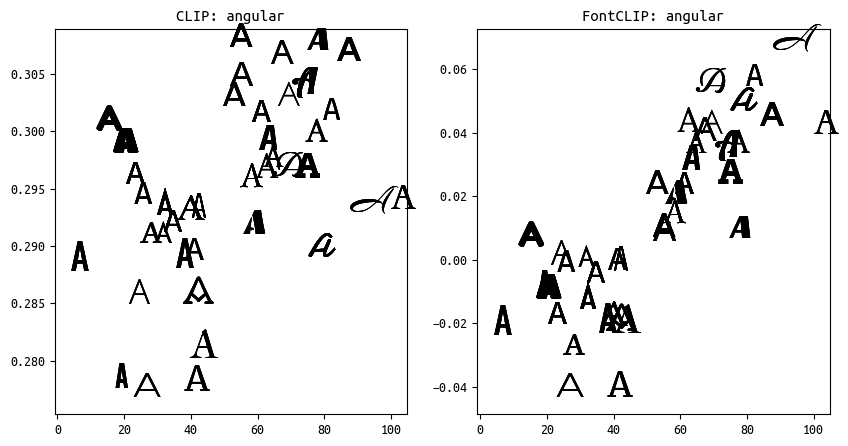

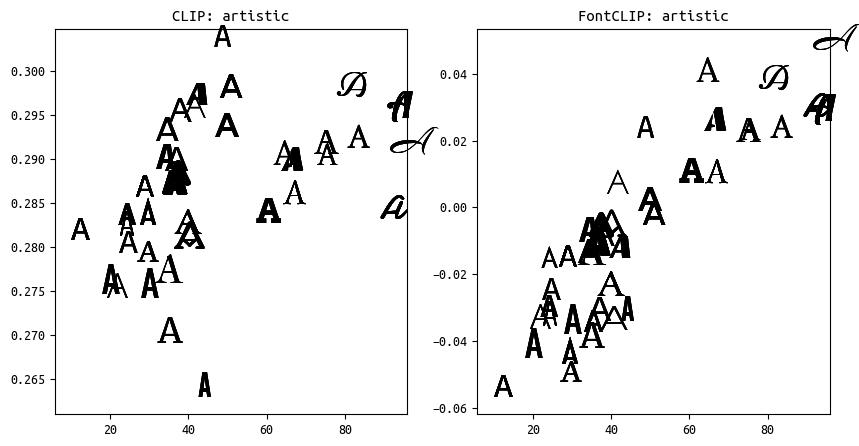

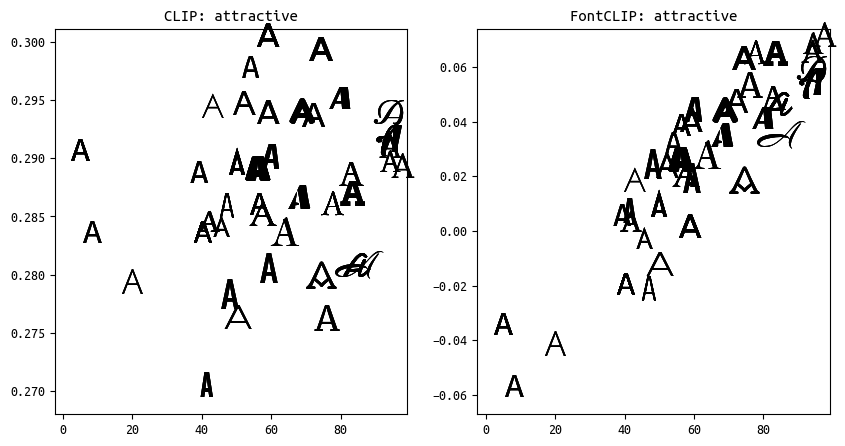

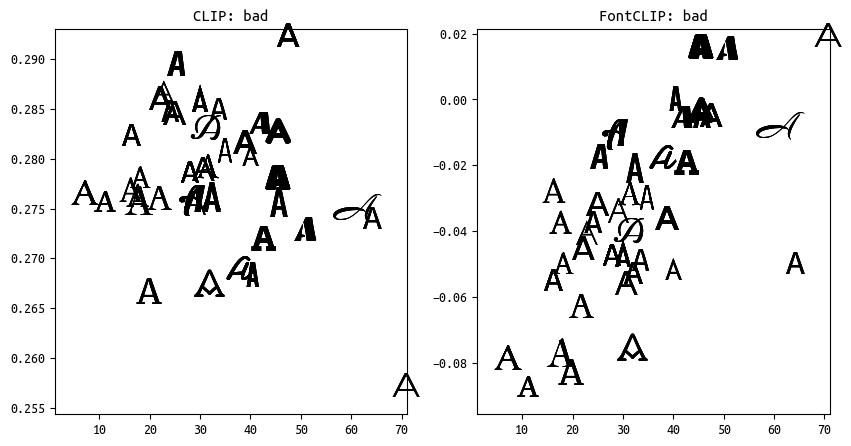

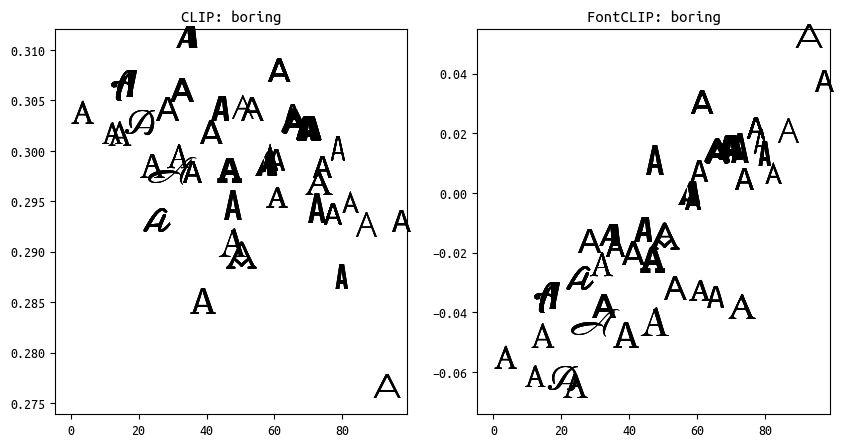

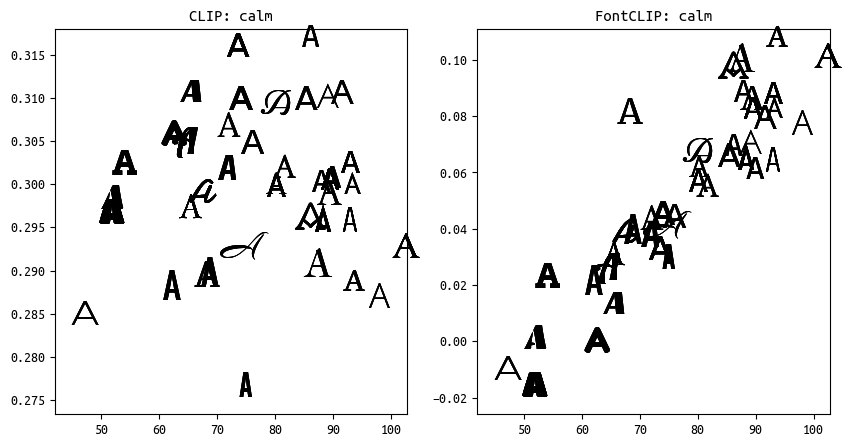

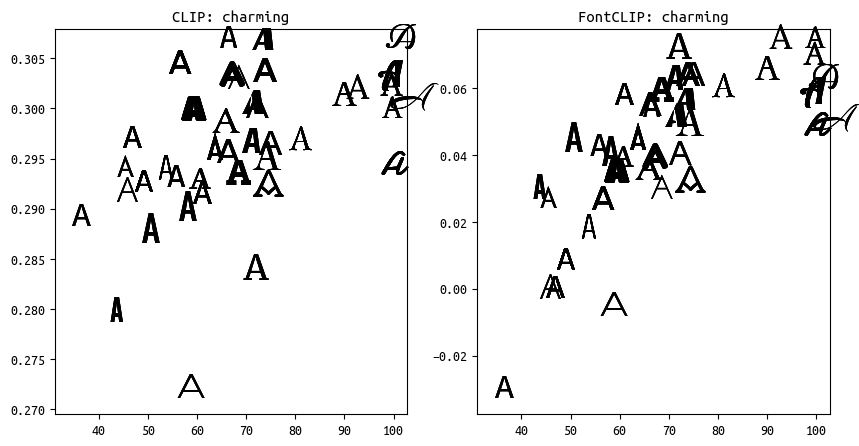

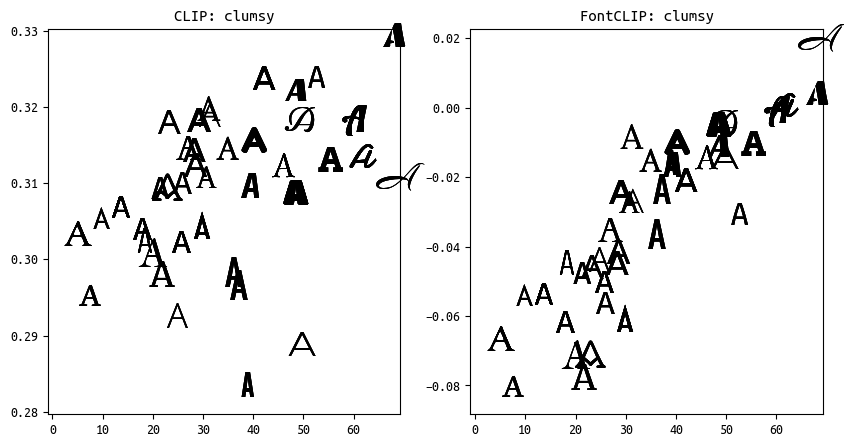

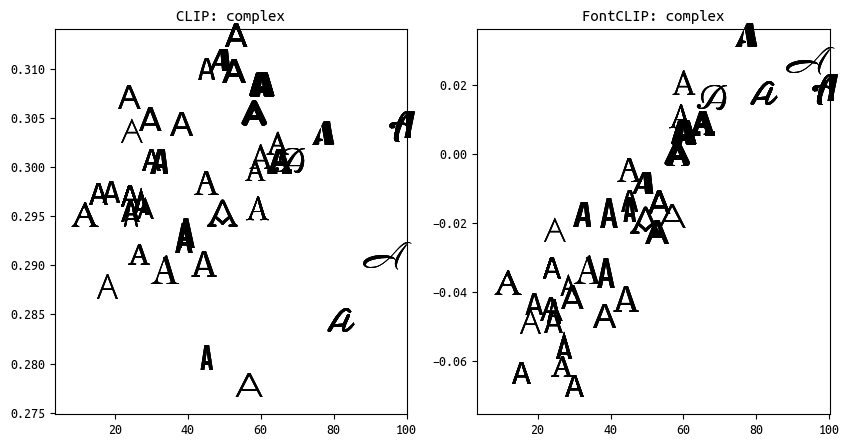

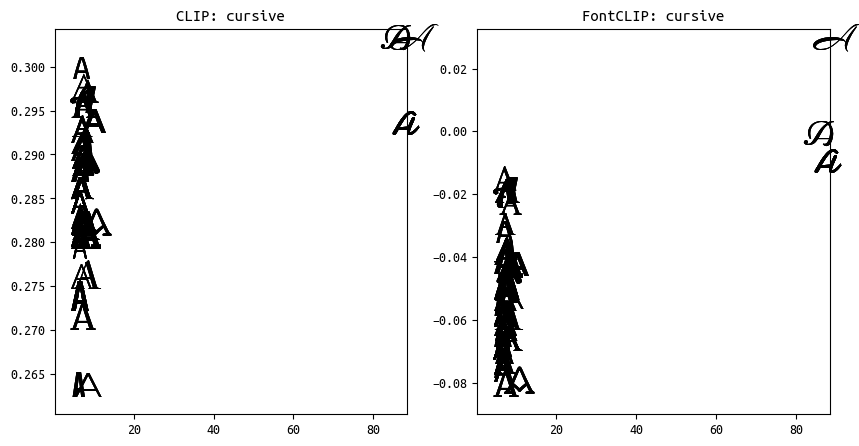

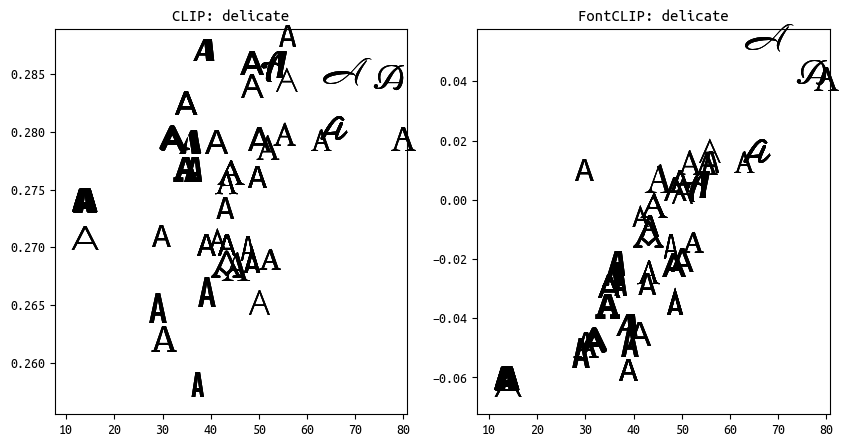

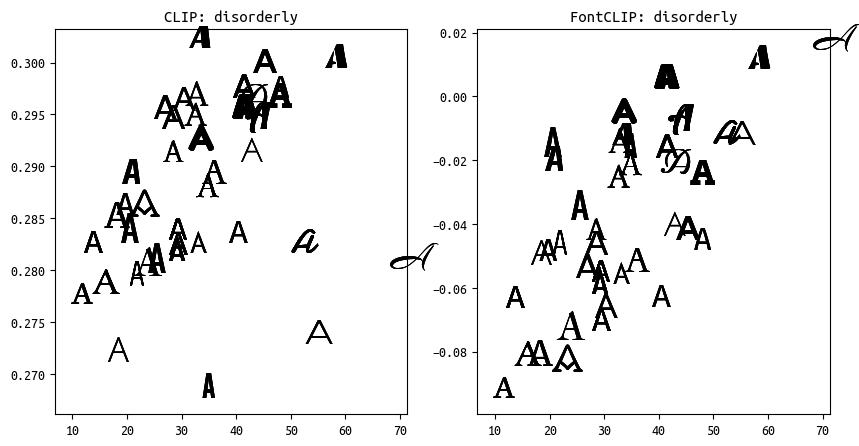

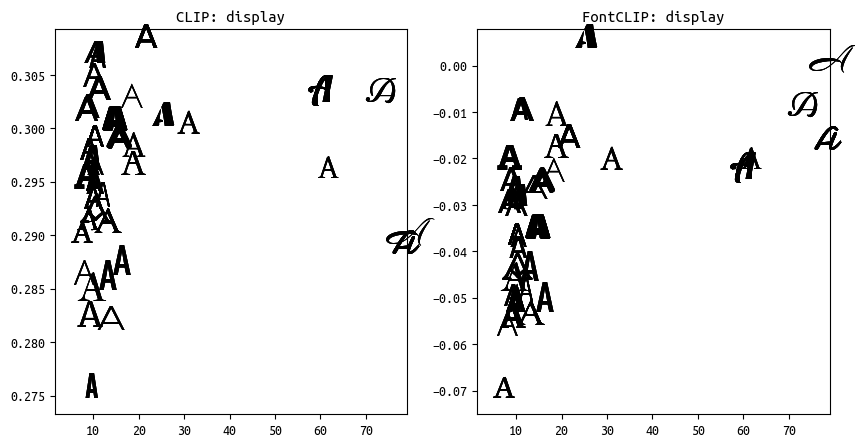

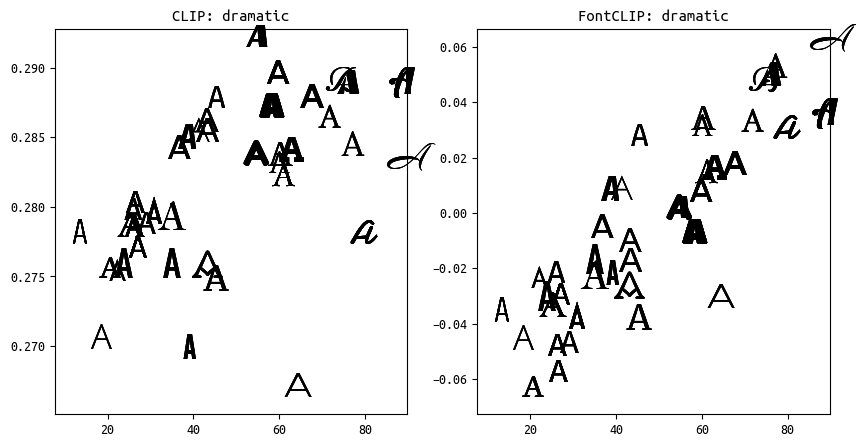

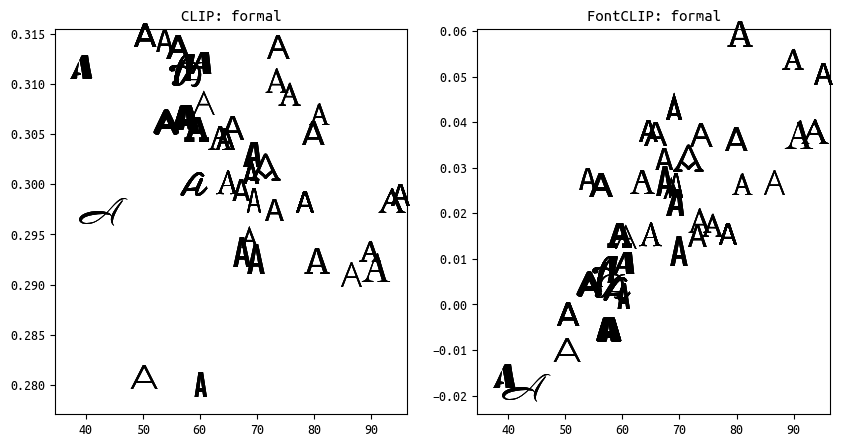

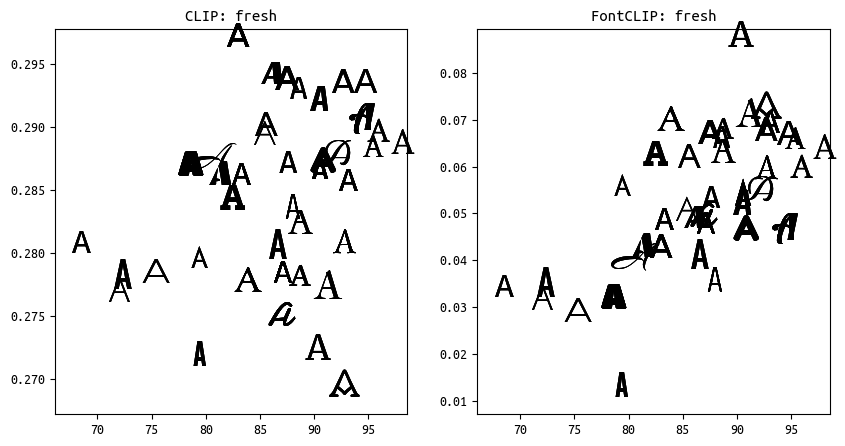

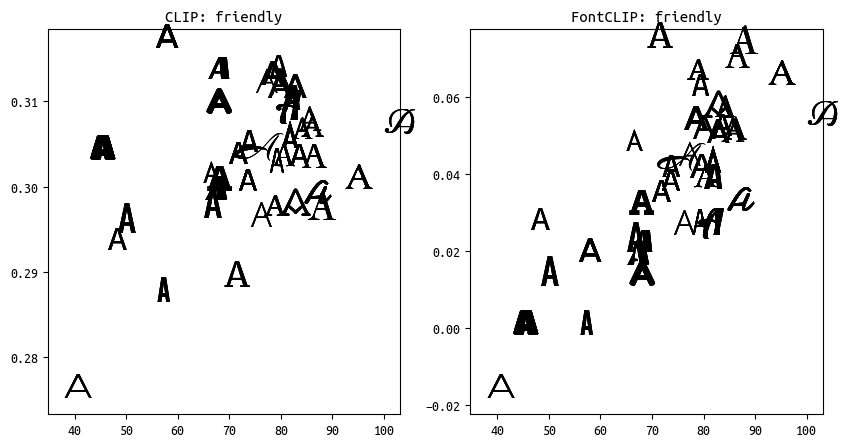

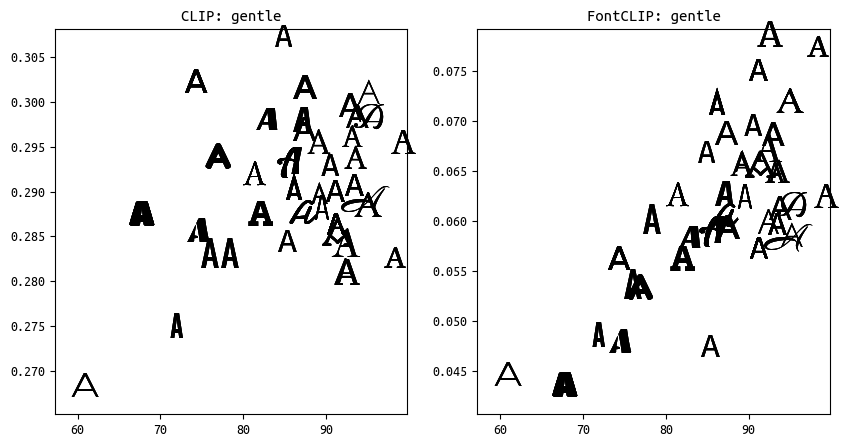

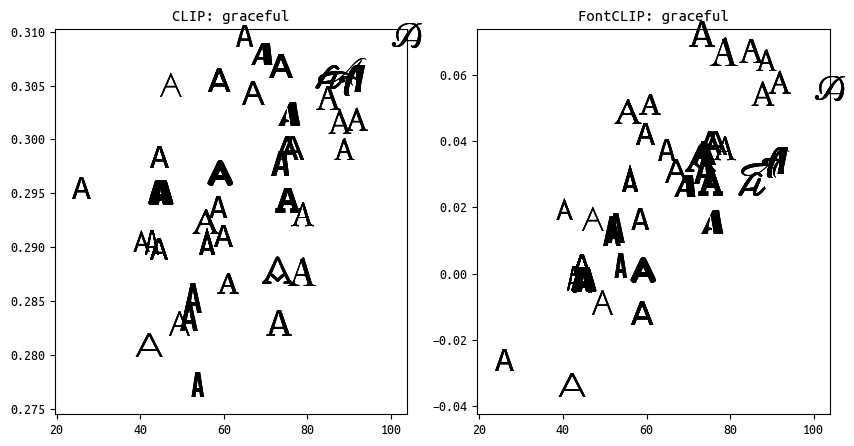

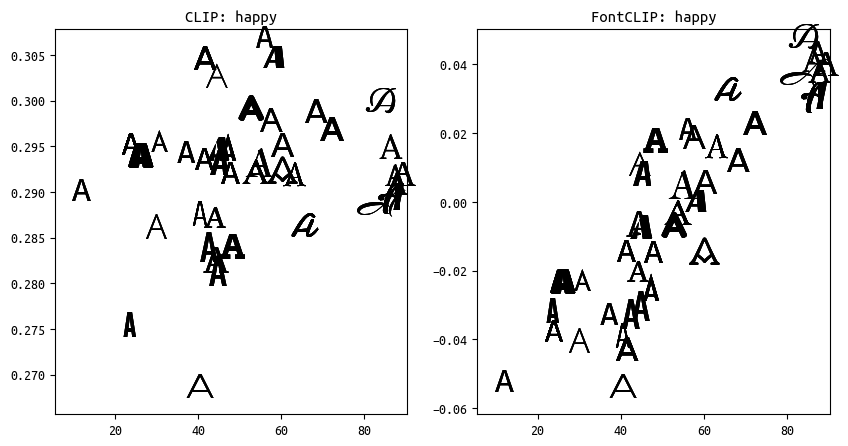

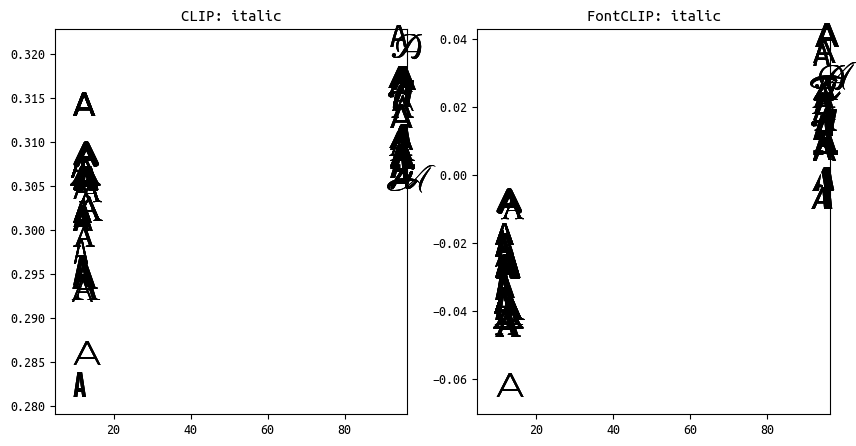

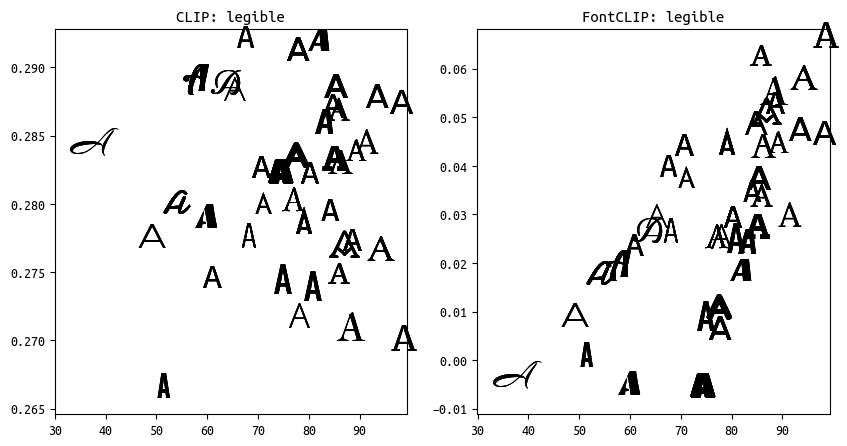

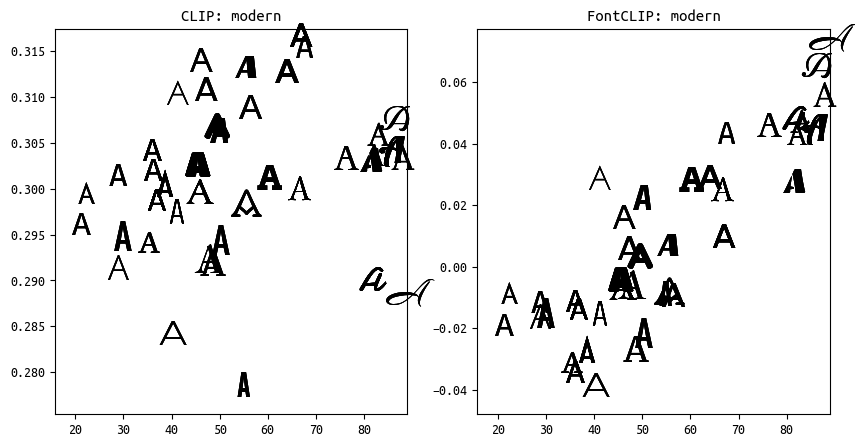

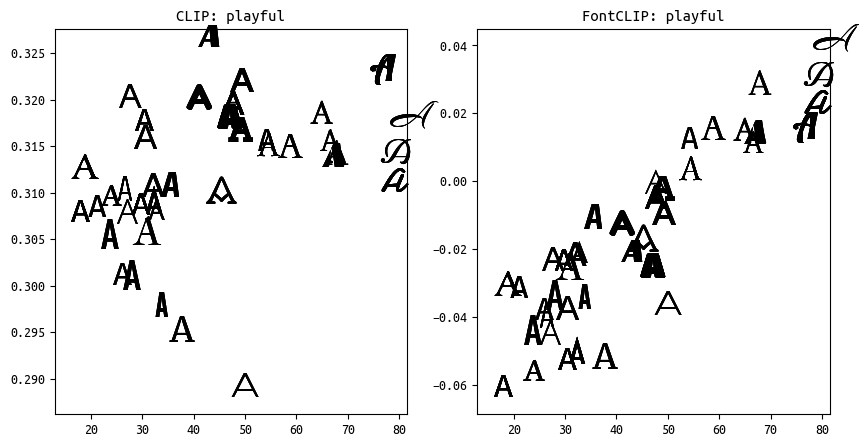

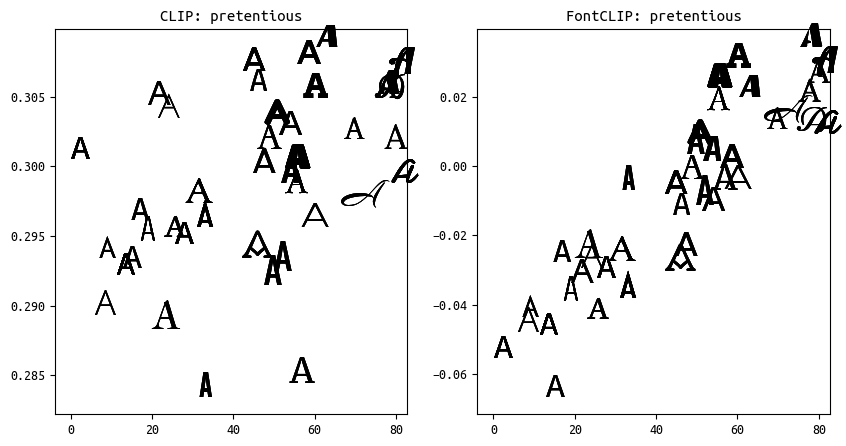

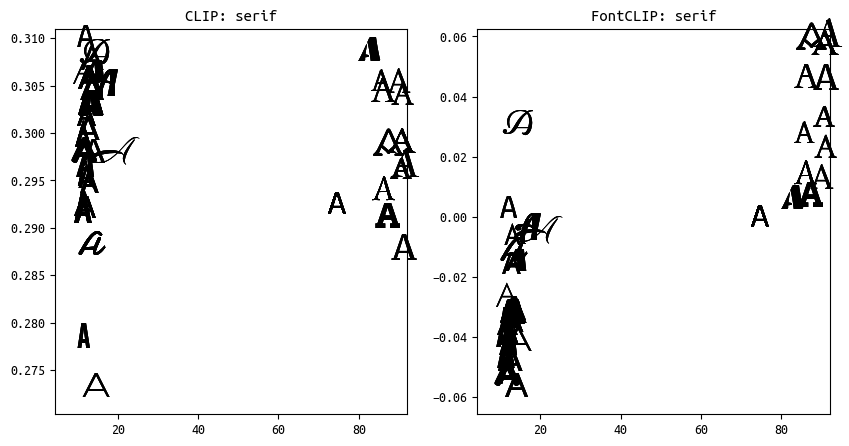

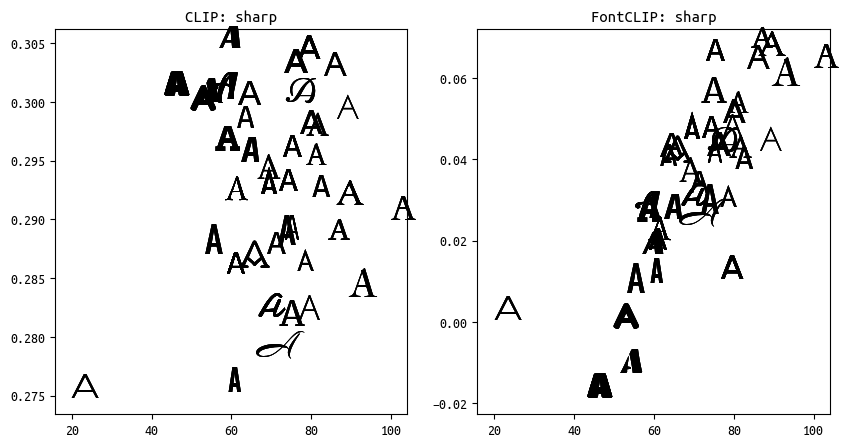

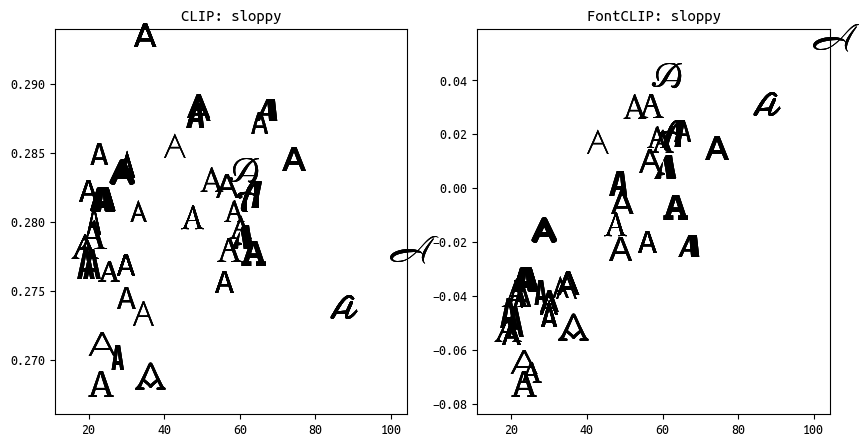

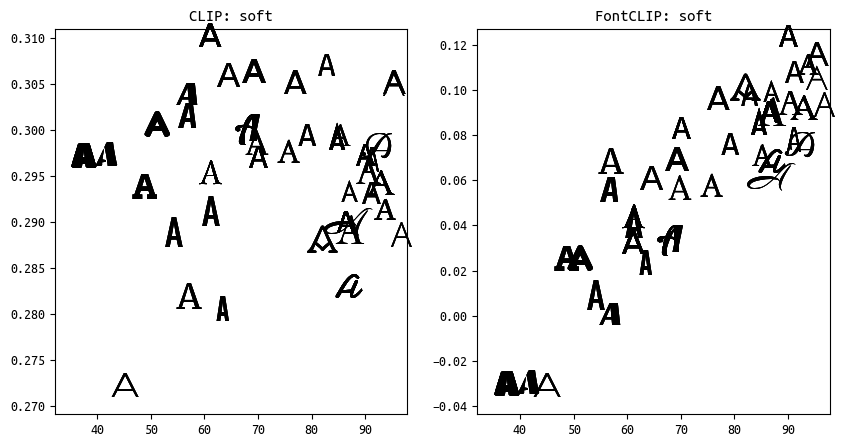

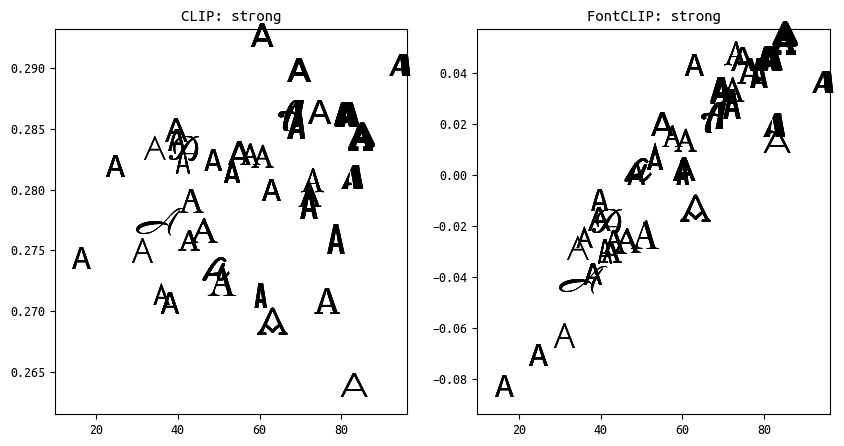

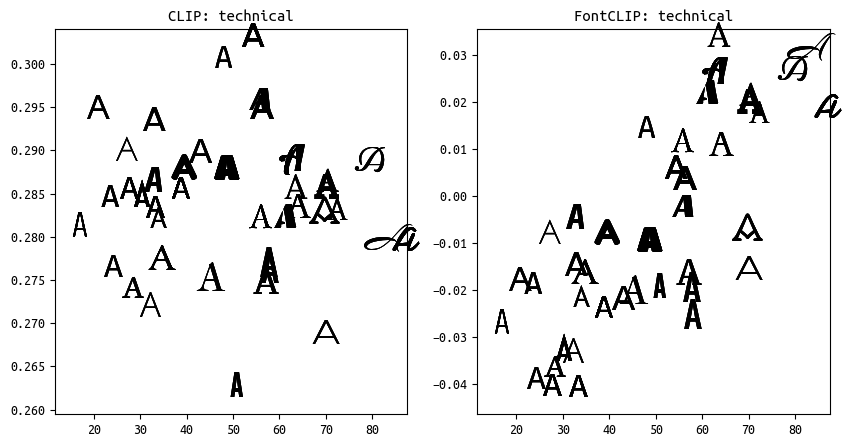

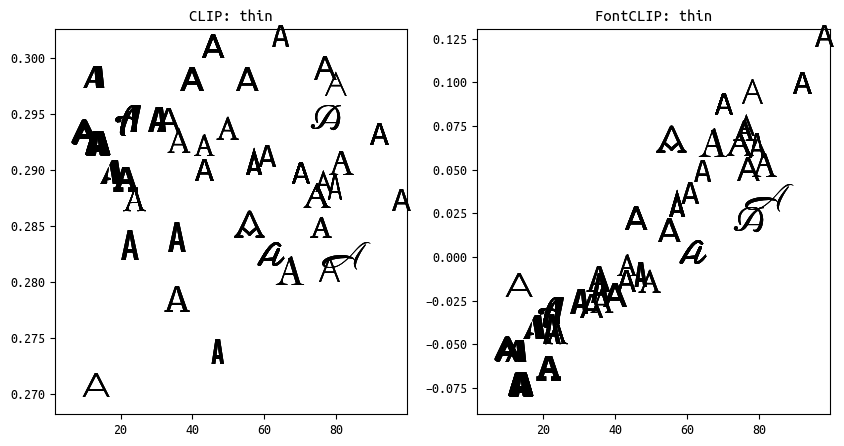

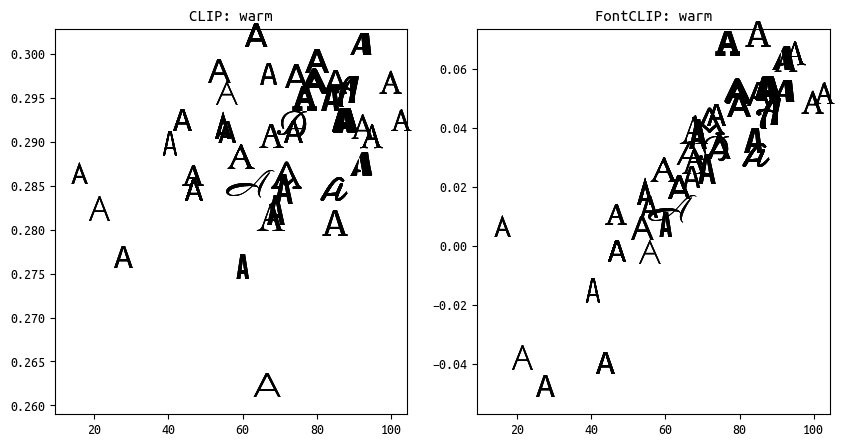

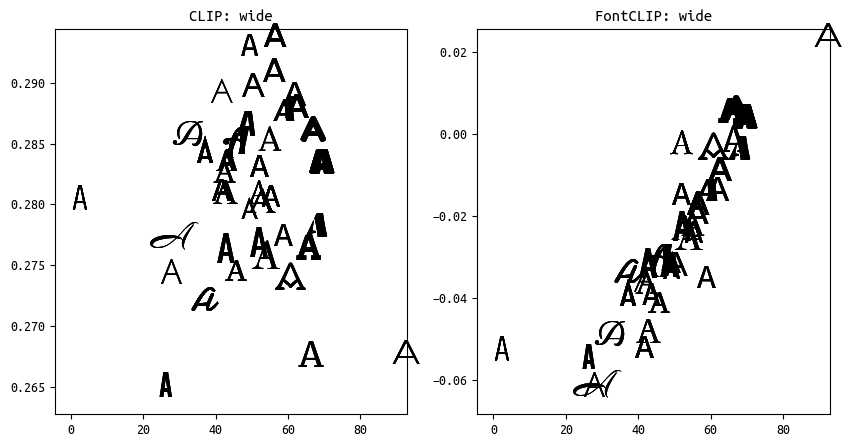

In [30]:
test_json_path = '../attributeData/test_font_to_attribute_values_5.json'
target_character = 'A'
for target_attribute in inclusive_attributes:
    if target_attribute == 'attention-grabbing':
        continue
    show_corr_figure(clip_model, fclip_model, test_json_path, target_attribute=target_attribute, text='A', save_fig=True)